In [6]:
import json
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale
import slugify

# math packages:
import pandas as pd
import numpy as np
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# the module that has all the methods for handling the data
# import resources.featuredata as featuredata

# home brew utitilties
# import resources.chart_kwargs as ck
# import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md
from IPython import display

# Plastock - Iqaasl

In [7]:
# clean the data for processing this step is a long process and should be avoided
# in the worst case this operation can be standardized if the data source cannot be changed
macro_csv = pd.read_csv("data/macro_csv.csv")
macro_csv.fillna(0, inplace=True)

# this is a remnant from exporting the csv from excel
macro_csv.drop("Unnamed: 11", axis=1, inplace=True)

# these dates were stored in a different format than all the others
bad_dates = ['8/13/2022', '10/15/2022', '11/6/2022']
macro_csv_bad_date = macro_csv[macro_csv["date"].isin(bad_dates)]
macro_csv = macro_csv[~macro_csv["date"].isin(bad_dates)].copy()

replace_with_key = {
    '8/13/2022': '08.13.2022',
    '10/15/2022': '10.15.2022',
    '11/6/2022': '11.06.2022'
}

citys_plastock = {
    'amphion': "Amphion-Publier",
    'aubonne': "Allaman",
    'baby-plage': "Genève",
    'bouveret': "Port-Valais",
    'clarens': "Montreux",
    'crans': "Crans",
    'cully': "Cully",
    'excenevex': "Excenevex",
    'gland': "Gland",
    'grangettes': "Noville",
    'lugrin': "Lugrin",
    'lutry': "Lutry",
    'meillerie': "Meillerie" ,
    'pichette': "Vevey",
    'port-choiseul': "Versoix",
    'preverenges': "Préverenges",
    'rolle': "Rolle",
    'tolochenaz': "Tolochénaz",
    'tougues': "Chens-sur-Léman",
    'vidy': "Lausanne" 
}
    
# replace with a key
macro_csv_bad_date["date"] = macro_csv_bad_date["date"].apply(lambda x: replace_with_key[x])

# put that back together
plastock_data = pd.concat([macro_csv, macro_csv_bad_date])

# these codes are stored as string tupled with no other correspondance.
# if taken by definition it is an aggregation of 78 and 79 which corresponds
# to Gfrags in IQAASL
macro_csv_bad_code = macro_csv[macro_csv.code.isin(['G78, G79', 'G79, G78'])].copy()
macro_csv = macro_csv[~macro_csv.code.isin(['G78, G79', 'G79, G78'])].copy()
macro_csv_bad_code["code"] = "G79"

# put that back together
plastock_data = pd.concat([macro_csv, macro_csv_bad_code])

# slug the location and then combine with date to make unique identifiers
plastock_data["slug"] = plastock_data.location.apply(lambda x: slugify.slugify(x))
plastock_data["loc_date"] = list(zip(plastock_data["slug"], plastock_data["date"]))
plastock_data["loc_date"] = plastock_data.loc_date.astype(str)

# convert to datetime
plastock_data["date"] = pd.to_datetime(plastock_data["date"], format="%d.%m.%Y")

# identify the project
plastock_data["project"] = "plastock"

# aggregated values are tested to against this
# set of data. Similar operations should result
# in similar results with the work data
plastock_data_save = plastock_data.copy()

# get code descriptions from the results.
plastock_codeData = plastock_data[["code", "description"]].copy()

# there are mulitple definitions for the same code. In this case we
# drop the duplicates from this list, keep the first. Aggregations can
# be made to the IQAASL data to account for the intentions of giving 
# multiple definitions to the same code. There are methods for dealing with this
# https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/code_groups.html#accounting-for-regional-objects
plastock_codeData = plastock_codeData.drop_duplicates("code")
plastock_codeData.to_csv("data/code_data_from_macro.csv", index=False)

# the beaches data has the lat and lon coordinates associated with each location name
beaches_csv = pd.read_csv("data/asl_beaches.csv")
beaches_csv.rename(columns={"Orientation": "orientation"}, inplace=True)

# making a slug removes all special characters and spaces, it is a cheap method to ensure
# that Genève is counted the same as Genéve when we are talking about the municpalities of
# Switzerland.
beaches_csv["slug"] = beaches_csv.location.apply(lambda x: slugify.slugify(x))
plastock_beaches= beaches_csv.drop_duplicates("location")

# this is a way to connect the name of the beach to its recorded length
# the mlw protocols suggest measuring the survey location at each itteration
beach_map_length = plastock_beaches[["slug", "length"]].set_index("slug")

# beach gps
beaches_csv_gps = plastock_beaches[["slug", "latitude", "longitude"]].set_index("slug")

# beach orientation
beaches_csv_orientation = plastock_beaches[["slug","orientation"]].set_index("slug")


# identify elements that are not in both sets of data
# the beach length is not readily identifiable there fore it can not
# be compared to the IQAASL data
no_beach_length = [x for x in plastock_data.slug.unique() if x not in plastock_beaches.slug.unique()]

# get code descriptions
plastock_codeData = plastock_data[["code", "description"]].copy()

# there are mulitple definitions for the same code. In this case we
# drop the duplicates from this list, keep the first. 
plastock_codeData = plastock_codeData.drop_duplicates("code")
plastock_codeData.to_csv("data/code_data_from_macro.csv", index=False)

# drop all the locations for which there is no beach length
# or gps data
plastock_data = plastock_data[~plastock_data.slug.isin(no_beach_length)].copy()

# map the lenght to the survey data
plastock_data['length'] = plastock_data.slug.map(lambda x: beach_map_length.loc[x, "length"])

# compute the pcs_m ratio from the lenght and the quantity
plastock_data["pcs_m"] = (plastock_data["quantity"]/plastock_data.length).round(2)
    
# indentify the variable columns  
var_cols = ['loc_date', 'project', 'location', 'date', 'season','area', 'time', 'position', 'substrate', 'code','slug']

# indentify the value columns
val_cols = [ 'quantity', 'weight', "pcs_m"]

# check should equal data by quantity
check = plastock_data_save[~plastock_data_save.slug.isin(no_beach_length)].quantity.sum()

# this combines all the different definitions for one code in to one.
work_data = plastock_data.groupby(var_cols, as_index=False).agg({"quantity":"sum", "weight": "sum", "pcs_m": "sum"})
work_data_save = work_data.copy()

# the quantity should be equal before and after the aggregation
check_quantity =  int(work_data.quantity.sum() - check == 0)

# the sum of the values with common loc_date should be equal
# if both sets of data are grouped by loc_date and totaled
# those totals should be equal before and after the aggregation
check_sample = plastock_data_save[~plastock_data_save.slug.isin(no_beach_length)].groupby("loc_date", as_index=False).quantity.sum()
data_check_sample = work_data.groupby("loc_date", as_index=False).quantity.sum()
check_event_totals = check_sample.quantity == data_check_sample.quantity

# the individual elements should also sum to zero
if check_quantity - check > 0:
    print("not good")
else:
    pass    
if sum(check_event_totals) == len(check_event_totals):
    pass
else:
    print("not good")

# there are aggregations that need to be made to the plastock data. The fragemented foams
# and fragmented plastics are consolidated into one group of codes. The plastic caps are consolidated
# as per the intend of the ASL and the recomendation from the IQAASL report.    
gfoam = ["G81", "G82", "G83"]
plasticpcs = [ "G78", "G79", "G80", "G75", "G76", "G77"]
Gcaps = [ "G21", "G23", "G24" ]

# the columns that are being kept and the operations per column          
columns = ['loc_date', 'project', 'location', 'date', 'area', 'slug']
operations = {"quantity":"sum", "weight": "sum", "pcs_m": "sum"}

# separate the codes of interest by group from the data frame and add the replacement value
work_data_gfrags = work_data[work_data.code.isin(plasticpcs)].groupby(columns, as_index=False).agg(operations)
work_data_gfoam = work_data[work_data.code.isin(gfoam)].groupby(columns, as_index=False).agg(operations)
work_data_gcaps = work_data[work_data.code.isin(Gcaps)].groupby(columns, as_index=False).agg(operations)

work_data_gcaps["code"] = "Gcaps"
work_data_gfoam["code"] = "Gfoam"
work_data_gfrags["code"] = "Gfrags"

# remove the same instances from the work data                                                               
work_data_no_frags = work_data[~work_data.code.isin([*plasticpcs, *gfoam, *Gcaps])].copy()

# combine with 
work_data = pd.concat([work_data_no_frags, work_data_gfrags, work_data_gfoam, work_data_gcaps])
work_data_save = work_data.copy()   
work_data = work_data[["project","slug", "date", "loc_date", "area", "code", "quantity", "pcs_m", "weight"]].copy()
work_data = work_data[["slug", "project", "loc_date", "date", "code", "quantity", "pcs_m"]].copy()
work_data.rename(columns={"slug": "location"}, inplace=True)

# begin IQAASL data
# iqaasl = pd.read_csv("resources/checked_sdata_eos_2020_21.csv")
# iqaasl = iqaasl[iqaasl.water_name_slug == 'lac-leman'].copy()
# save to the repo
# iqaasl.to_csv("data/lac_leman_iqaasl.csv", index=False)
iqaasl = pd.read_csv("data/lac_leman_iqaasl.csv")


# select columns from iqaasl data and aggregate gcaps
iqaasl_data = iqaasl[['location', 'date', 'loc_date', 'code',  'quantity','pcs_m']].copy()

# identify the data
iqaasl_data["project"] = "iqaasl"

# make gcaps, gfrags and foams are ready made
iqaasl_not_caps = iqaasl_data[~iqaasl_data.code.isin(Gcaps)].copy()
iqaasl_caps = iqaasl_data[iqaasl_data.code.isin(Gcaps)].copy()
iqaasl_caps["code"] = "Gcaps"

iqaasl_data = pd.concat([iqaasl_caps, iqaasl_not_caps])

palette = {"plastock": "magenta", "iqaasl": "dodgerblue"}

nwd = pd.concat([iqaasl_data, work_data])
nwd["date"] = pd.to_datetime(nwd["date"])

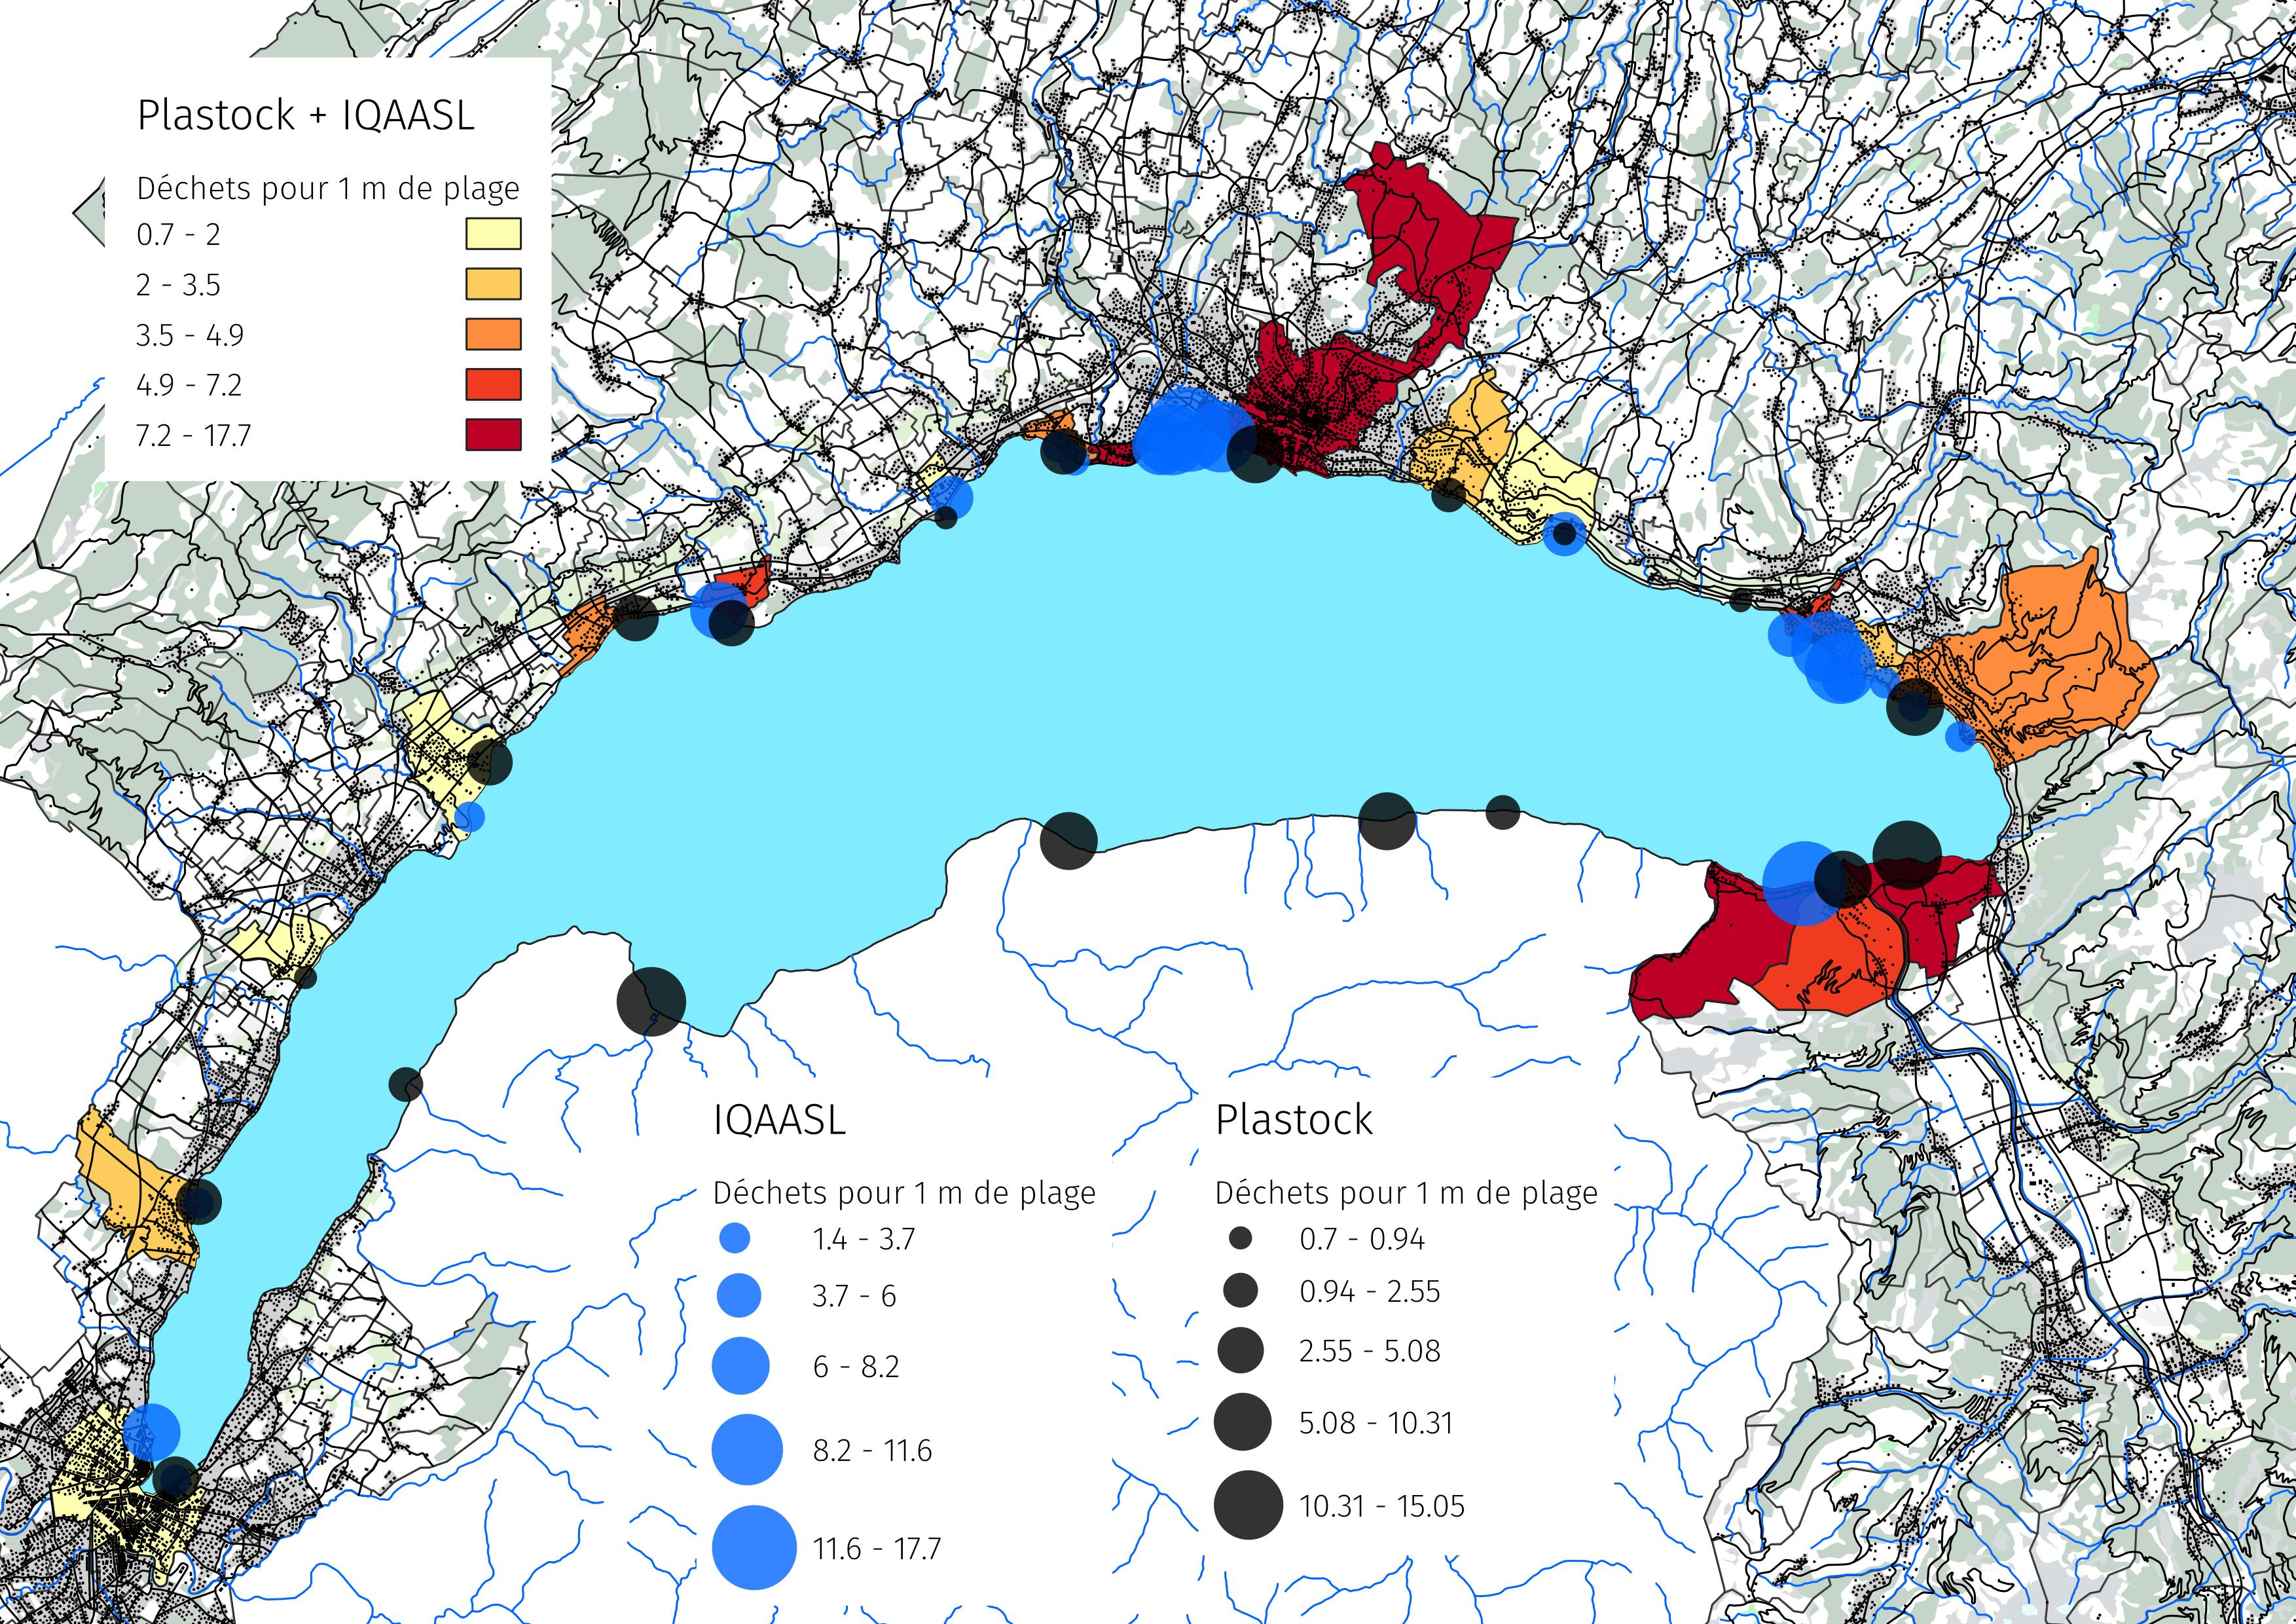

In [8]:
display.Image("data/images/new_map.jpg")

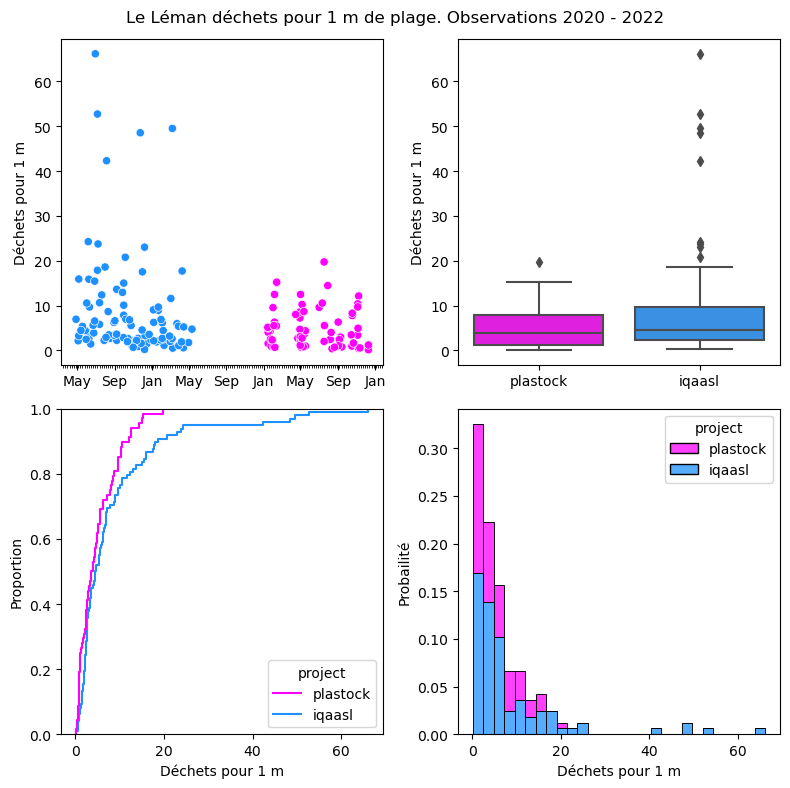

In [9]:
nwdt = nwd.groupby(["loc_date","project", "date"], as_index=False).pcs_m.sum()

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
# Minor ticks every year.
fmt_year = mdates.YearLocator()

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

fig, ax = plt.subplots(2,2, figsize=(8,8))

sns.scatterplot(nwdt, x="date", y="pcs_m", palette=palette, hue="project", ax=ax[0,0])
ax[0, 0].xaxis.set_minor_locator(days)
ax[0, 0].xaxis.set_major_formatter(months_fmt)
ax[0, 0].legend().remove()
ax[0, 0].set_ylabel("Déchets pour 1 m")
ax[0, 0].set_xlabel("")
sns.boxplot(data=nwdt, x="project", y="pcs_m", palette=palette, hue="project", ax=ax[0,1], dodge=False)
ax[0,1].legend().remove()
ax[0, 1].set_ylabel("Déchets pour 1 m")
ax[0, 1].set_xlabel("")
sns.ecdfplot(data=nwdt, x="pcs_m", hue="project", palette=palette, ax=ax[1, 0])
ax[1, 1].set_ylabel("Probailité")
ax[1, 1].set_xlabel("Déchets pour 1 m")
ax[1, 0].set_xlabel("Déchets pour 1 m")
sns.histplot(data=nwdt, x="pcs_m", hue="project", palette=palette, ax=ax[1,1], multiple="stack", stat="probability")

plt.suptitle("Le Léman déchets pour 1 m de plage. Observations 2020 - 2022")

plt.tight_layout()

plt.show()

In [10]:
summary_iqaasl_dt = nwdt[nwdt.project == "iqaasl"].pcs_m.describe()
iqaasl_total = pd.Series({"total":nwd[nwd.project == "iqaasl"].quantity.sum()})
summary_iqaasl_dt = pd.concat([summary_iqaasl_dt, iqaasl_total])


summary_plastock_dt = nwdt[nwdt.project == "plastock"].pcs_m.describe()
plastock_total = pd.Series({"total":nwd[nwd.project == "plastock"].quantity.sum()})
summary_plastock_dt = pd.concat([summary_plastock_dt, plastock_total])


f = f"""

NOTE: mean = moyen, count=nombre d'événements, std=écart type

Résumé des totaux d'échantillons 'Plastock':

{summary_plastock_dt}

Résumé des totaux d'échantillons 'IQAASL':

{summary_iqaasl_dt}


"""
print(f)



NOTE: mean = moyen, count=nombre d'événements, std=écart type

Résumé des totaux d'échantillons 'Plastock':

count       68.000000
mean         5.012206
std          4.423880
min          0.150000
25%          1.190000
50%          3.795000
75%          7.832500
max         19.730000
total    25218.000000
dtype: float64

Résumé des totaux d'échantillons 'IQAASL':

count       98.000000
mean         8.671122
std         11.681734
min          0.220000
25%          2.325000
50%          4.505000
75%          9.682500
max         66.170000
total    27462.000000
dtype: float64





In [11]:
mc_codes = [
    'Gcaps',
    'Gfrags',
    'Gfoam',
    'G27',
    'G30',
    'G112',
    'G95',
    'G74',
    'G67',
    'G117',
    'G89',
    'G200',
    'G70',
    'G178',
    'G25',
    'G10',
    'G35',
    'G23',
    'G31',
    'G33',
    'G32',
    'G177',
    'G100'
]


nwd_common = nwd[nwd.code.isin(mc_codes)].copy()
nwd_common.fillna(0, inplace=True)
# fig, ax = plt.subplots()
operations = {"quantity":"sum", "pcs_m": "median"}

dx = nwd_common.groupby(["project", "code"], as_index=False).agg(operations)

dx = dx.pivot(index="code", columns="project", values="pcs_m")
mcommon = f"""

Comparaison des codes les plus courants Le Léman 2020 - 2021

{dx}

"""

print(mcommon)



Comparaison des codes les plus courants Le Léman 2020 - 2021

project  iqaasl  plastock
code                     
G10       0.010     0.010
G100      0.020     0.020
G112      0.000     0.110
G117      0.000     0.060
G177      0.020     0.040
G178      0.030     0.020
G200      0.030     0.400
G25       0.020     0.010
G27       0.470     0.130
G30       0.215     0.130
G31       0.030     0.030
G32       0.025     0.020
G33       0.020     0.015
G35       0.040     0.020
G67       0.090     0.040
G70       0.010     0.030
G74       0.100     0.050
G89       0.055     0.040
G95       0.120     0.130
Gcaps     0.025     0.050
Gfoam     0.260     0.140
Gfrags    0.615     0.240




In [12]:
# by code and by location
map_pcs_m = nwdt[["loc_date", "pcs_m"]].set_index("loc_date")

dcopy = work_data_save.copy()
dcopy["p/m²"] = dcopy["quantity"]/dcopy["area"]

# indentify the variable columns  
var_cols = ['loc_date', 'project', 'location', 'date', 'season','area', 'time', 'position', 'substrate', 'code','slug']

# indentify the value columns
val_cols = [ 'quantity', 'weight', "time", "p/m²"]

# sum operations
operations = {"quantity":"sum", "weight": "sum", "p/m²":"sum"}

# operation columns
ops_cols = ['loc_date', 'project', 'location', 'date', 'slug']

# points cardinal
cardinal = {
    'OSO':247.5, 'NO': 315, 'NNE': 22.5, 'N':0, 'ESE':112.5, 'SSE':157.5, 'E':90, 'SSO':202.5, 'S':180, 'ONO':292.5, 'O':270,
       'SO':225, 'SE':135, 'ENE':67.5, 'NE':45, 'NNO': 337.5}

regions = {
    'Hermance':"petit-lac",
    'Savonière': "petit-lac",
    'Baby plage': "petit-lac",
    'Versoix': "petit-lac",
    'Crans':"petit-lac",
    'Gland':"grand-lac",
    'Rolle':"grand-lac",
    'Aubonne':"grand-lac",
    'Tolochenaz':"grand-lac",
    'Préverenges':"grand-lac",
    'Vidy':"grand-lac", 
    'Lutry':"grand-lac",
    'Cully':"grand-lac",
    'Pichette':"haut-lac",
    'Clarens': "haut-lac",
    'Grangettes':"haut-lac",
    'Bouveret':"haut-lac",
    'Tougues': "petit-lac",
    'Excenevex':"grand-lac",
    'Meillerie':"haut-lac",
    'Lugrin':"grand-lac",
    'Amphion':"grand-lac",
    'Anthy':"grand-lac",
    'Port choiseul':"petit-lac",
    'Saint-Disdille':"grand-lac"   
}

dxt = dcopy.groupby(ops_cols, as_index=False).agg(operations)
dxt["p/m"] = dxt.loc_date.map(lambda x: map_pcs_m.loc[str(x), "pcs_m"])
dxt["orientation"] = dxt.location.map(lambda x: beaches_csv_orientation.loc[slugify.slugify(x), "orientation"])
dxt["lat"] = dxt.location.map(lambda x: beaches_csv_gps.loc[slugify.slugify(x), "latitude"])
dxt["lon"] = dxt.location.map(lambda x: beaches_csv_gps.loc[slugify.slugify(x), "longitude"])
dxt["city"] = dxt.slug.map(lambda x: citys_plastock[x])
dxt["pc"] = dxt.orientation.map(lambda x: cardinal[x])
dxt["region"] = dxt.location.map(lambda x: regions[x])
dxt_display = dxt.groupby(["location", "city", "region", "lat", "lon", "pc", "orientation"], as_index=False).agg({"quantity":"sum", "weight": "sum", "p/m²":"mean", "p/m": "median", "loc_date": "nunique"})
dxt_display.rename(columns={"loc_date": "samples"}, inplace=True)

gis_out_plastock = dxt_display[["location", "city", "lat", "lon", "pc",  "region", "quantity", "weight", "p/m²", "p/m", "samples"]].copy()

dxt_display_city = dxt.groupby(["city", "region", "lat", "lon", "pc"], as_index=False).agg({"quantity":"sum", "weight": "sum", "p/m²":"mean", "p/m": "median", "loc_date": "nunique"})
dxt_display_city.rename(columns={"loc_date": "samples"}, inplace=True)

# dxt_display_city.to_csv("resources/plastock_city_macro.csv", index=False)
# gis_out_plastock.to_csv("resources/plastock_macro.csv", index=False)
# dxt_city_summary = dxt_display_city = dxt.groupby(["city", "region"], as_index=False).agg({"quantity":"sum", "weight": "sum", "p/m²":"mean", "p/m": "median", "loc_date": "nunique"})

city_map = dxt[["city", "lat", "lon"]].set_index("city")

# dxt_city_summary["lat"] = dxt_city_summary.city.map(lambda x: city_map.loc[x, "lat"])
# dxt_city_summary["lon"] = dxt_city_summary.city.map(lambda x: city_map.loc[x, "lon"])

locations = f"""

Résumé par localité:

{gis_out_plastock[["location", "quantity", "weight", "p/m²", "p/m", "samples"]]}


"""
print(locations)




Résumé par localité:

         location  quantity     weight      p/m²     p/m  samples
0         Amphion      2505   8.008169  2.628312   6.650        4
1         Aubonne       812   4.170334  1.295813   3.490        4
2      Baby plage      1173  14.355139  1.108352   3.465        4
3        Bouveret       836  26.391915  8.444444   7.230        1
4         Clarens      1399   8.389276  3.296175   8.530        3
5           Crans        74   0.869780  1.156250   0.940        4
6           Cully        88   0.741463  0.648397   0.945        4
7       Excenevex      1804   5.027917  2.182116  15.050        1
8           Gland       300   1.348070  3.377470   3.390        4
9      Grangettes      3909  12.992625  6.243659  13.850        4
10         Lugrin      3019  55.200694  7.098926  10.310        4
11          Lutry       143   0.478920  1.029360   2.240        1
12      Meillerie       183   0.787206  0.863208   2.180        4
13       Pichette       102   0.579582  0.505501   0

In [ ]:
# Résumé par code et emplacement
pd.set_option('display.max_rows', 1000)

plastock_data["p/m²"] = plastock_data["quantity"]/plastock_data["area"]
code_location = plastock_data.groupby(["location", "code"], as_index=False).agg({"weight": "sum", "pcs_m":"median", "p/m²":"mean"})
code_location

In [ ]:
with open("resources/region_city.json", "r") as afile:
    
    region_city = json.load(afile)
    

def unpackRegions(region_city):
    
    new_d = {}
    for k, v in region_city.items():
        for city in v:
            new_d[city] = k
    return new_d

region_city_map = unpackRegions(region_city)

orientate_iqaasl = pd.read_csv("data/export_oriented_layer_iqaasl.csv")

area_iqaasl = admin_details.dims_data[["loc_date","area"]].set_index("loc_date")
weight_iqaasl = admin_details.dims_data[["loc_date","total_w"]].set_index("loc_date")
admin_details.df_beaches["slug"] = admin_details.df_beaches.location.apply(lambda x: slugify.slugify(x))

iqt_gps = admin_details.df_beaches[["slug", "latitude", "longitude"]].set_index("slug")
iqt_city = admin_details.df_beaches[["slug", "city"]].set_index("slug")

iqt = nwd[nwd.project == "iqaasl"].copy()
iqt["slug"] = iqt.location.apply(lambda x: slugify.slugify(x))
iqt["area"] = iqt.loc_date.map(lambda x: area_iqaasl.loc[str(x), "area"])
iqt["p/m²"] = iqt.quantity/iqt.area
iqt["city"] = iqt.slug.apply(lambda x: iqt_city.loc[x, "city"])
iqt["region"] = iqt.city.map(lambda x: region_city_map[x])
iqt.rename(columns={"pcs_m": "p/m"}, inplace=True)

iqt = iqt.groupby(["loc_date", "location", "city", "region", "slug"], as_index=False).agg({"quantity":"sum", "p/m²":"sum", "p/m": "sum"})
iqt["weight"] = iqt.loc_date.map(lambda x: weight_iqaasl.loc[str(x), "total_w"])
iqt["pc"] = 0



iqt["lat"] =  iqt.slug.map(lambda x: iqt_gps.loc[x, "latitude"])
iqt["lon"] = iqt.slug.map(lambda x: iqt_gps.loc[x, "longitude"])


iqt_display = iqt.groupby(["location", "city", "lat", "lon", "region", "pc"], as_index=False).agg({"quantity":"sum", "p/m²":"mean", "p/m": "median", "weight": "sum", "loc_date": "nunique"})
iqt_display.rename(columns = {"loc_date": "samples"} , inplace=True)


# iqt_display[["location", "city", "lat", "lon", "pc",  "region", "quantity", "weight", "p/m²", "p/m", "samples"]].to_csv("resources/iqaasl_location_macro.csv", index=False)

city_gps = iqt[["city", "lat", "lon"]].drop_duplicates("city").set_index("city")
city_orientation = orientate_iqaasl.groupby("city").pc.mean()


iqt_display_city = iqt.groupby(["city", "region"], as_index=False).agg({"quantity":"sum", "weight": "sum", "p/m²":"mean", "p/m": "median", "loc_date": "nunique"})
iqt_display_city.rename(columns={"loc_date": "samples"}, inplace=True)
iqt_display_city["lat"] =  iqt_display_city["city"].map(lambda x: city_gps.loc[x, "lat"])
iqt_display_city["lon"] = iqt_display_city["city"].map(lambda x: city_gps.loc[x, "lon"])
iqt_display_city["pe"] = iqt_display_city["city"].map(lambda x: city_orientation.loc[x])




# iqt_display_city.to_csv("resources/iqaasl_city_macro.csv", index=False)
# iqt_display[["location", "city", "lat", "lon", "pc",  "region", "quantity", "weight", "p/m²", "p/m", "samples"]]
iqt_display_city